# Qutrits for portfolio optimization


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!pip install cirq --quiet
!pip install yfinance --quiet

In [206]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

from tqdm import tqdm

import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
from cirq import PauliSum

In [60]:
%cd /content/drive/MyDrive/RQC_Tasks/Qudits/qudits-vqc

from qudit_depolarization_channels import *
from qudit_gates import *

/content/drive/MyDrive/RQC_Tasks/Qudits/qudits-vqc


In [61]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

import yfinance as yf

import cirq
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit

In [62]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR) # remove annoying SVGCircuit warnings

# Classical financial optimization

In [177]:
tickers = ['IBM', 'TEL', 'META', 'GOOG']
N = len(tickers)

start_date = '2021-01-01'
end_date = '2023-01-01'

panel_data = yf.download(tickers, start=start_date, end=end_date)
panel_data.head()

[*********************100%***********************]  4 of 4 completed


Adj Close                                          Close  \
                 GOOG         IBM        META         TEL       GOOG   
Date                                                                   
2021-01-04  86.412003  104.750328  268.940002  116.209740  86.412003   
2021-01-05  87.045998  106.609718  270.970001  118.441185  87.045998   
2021-01-06  86.764503  109.272003  263.309998  121.841507  86.764503   
2021-01-07  89.362503  109.018448  268.739990  124.285500  89.362503   
2021-01-08  90.360497  108.629669  267.570007  126.033958  90.360497   

                                                     High              ...  \
                   IBM        META         TEL       GOOG         IBM  ...   
Date                                                                   ...   
2021-01-04  118.489487  268.940002  120.300003  88.032501  120.382408  ...   
2021-01-05  120.592735  270.970001  122.610001  87.383499  121.108986  ...   
2021-01-06  123.604210  263.309998  126.129997  87.400002  126.080307  ...   
2021-01-07  123.317398  268.739990  128.660004  89.419998  124.722755  ...   
2021-01-08  122.877632  267.570007  130.470001  90.491997  123.632889  ...   

                   Low                   Open                          \
                  META         TEL       GOOG         IBM        META   
Date                                                                    
2021-01-04  265.200012  118.980003  87.876999  120.315491  274.779999   
2021-01-05  268.209991  120.389999  86.250000  119.512428  268.290009   
2021-01-06  260.010010  124.449997  85.131500  121.319313  262.000000   
2021-01-07  264.779999  126.800003  87.002998  124.321220  265.899994   
2021-01-08  263.179993  128.240005  89.399002  122.915871  268.309998   

                          Volume                              
                   TEL      GOOG      IBM      META      TEL  
Date                                                          
2021-01-04  121.190002  38038000  5417443  15106100  1386500  
2021-01-05  120.669998  22906000  6395872   9871600  1191400  
2021-01-06  125.000000  52042000  8322708  24354100  2306100  
2021-01-07  127.160004  45300000  4714740  15789800  1875000  
2021-01-08  129.889999  41012000  4891305  18528300  2301300  

[5 rows x 24 columns]

In [178]:
data = panel_data['Close'].pct_change()
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
data.reindex(all_weekdays)
data.fillna(method='ffill')

data.tail()

,GOOG,IBM,META,TEL
Date,,,,
2022-12-23,0.017562,0.005466,0.007855,-0.002451
2022-12-27,-0.020933,0.005436,-0.009827,-0.000790
2022-12-28,-0.016718,-0.016852,-0.010780,-0.014316
2022-12-29,0.028799,0.007427,0.040131,0.030384
2022-12-30,-0.002473,-0.001205,0.000665,-0.007264


Вектор средней дневной доходности.

In [179]:
R = data.mean()
R

GOOG    0.000258
IBM     0.000457
META   -0.001080
TEL     0.000076
dtype: float64

Необходимо построить матрицу дневных ковариаций на данном временном промежутке

,GOOG,IBM,META,TEL
GOOG,0.000413,0.000078,0.000420,0.000231
IBM,0.000078,0.000223,0.000066,0.000102
META,0.000420,0.000066,0.000995,0.000274
TEL,0.000231,0.000102,0.000274,0.000337


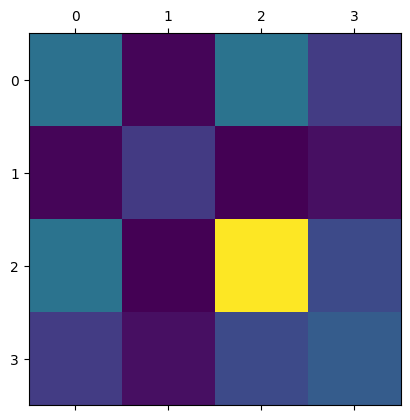

In [180]:
cov = data.cov()
plt.matshow(cov)
cov

### Случайные тернарные портфели

Научимся генерировать случайные тернарные портфели - вектора размерности N со значениями -1, 0 и 1

In [181]:
def randBinPortf():
  return np.random.randint(3, size=N)

Доходность портфеля считаем как скалярное произведение вектора средней дневной доходности на s

Риск оценивается первым слагаемым в формуле Марковица



In [182]:
def dohPortf(s):
    return np.matmul(R.values,s)
    
def riskPortf(s):
    return np.matmul(np.matmul(s,cov.values),s)

def markovitz_form(s, risk_fear=1):
    return riskPortf(s) * risk_fear - dohPortf(s)

In [183]:
s = randBinPortf()

print(dohPortf(s))
print(riskPortf(s))

-0.001109308036513322
0.012350989879503158


### Генерация всех тернарных портфелей

Нужно сгенерировать все 3^N возможных тернарных портфелей

In [184]:
ternary_strings = [np.base_repr(x,base=3).rjust(N, '0') for x in range(3**N)]

ternary_portfolio = [[int(symbol) - 1 for symbol in string] for string in ternary_strings]

ternary_portfolio[:10]

[[-1, -1, -1, -1],
 [-1, -1, -1, 0],
 [-1, -1, -1, 1],
 [-1, -1, 0, -1],
 [-1, -1, 0, 0],
 [-1, -1, 0, 1],
 [-1, -1, 1, -1],
 [-1, -1, 1, 0],
 [-1, -1, 1, 1],
 [-1, 0, -1, -1]]

In [185]:
L = 3 ** N

risk = np.zeros(L)
doh = np.zeros(L)
Q = np.zeros(L)
portf = np.zeros((L, N))

for i in range(L):

  r = ternary_portfolio[i]
    
  portf[i,:] = r
  risk[i] = riskPortf(r)
  doh[i] = dohPortf(r)
  Q[i] = risk[i] - doh[i]

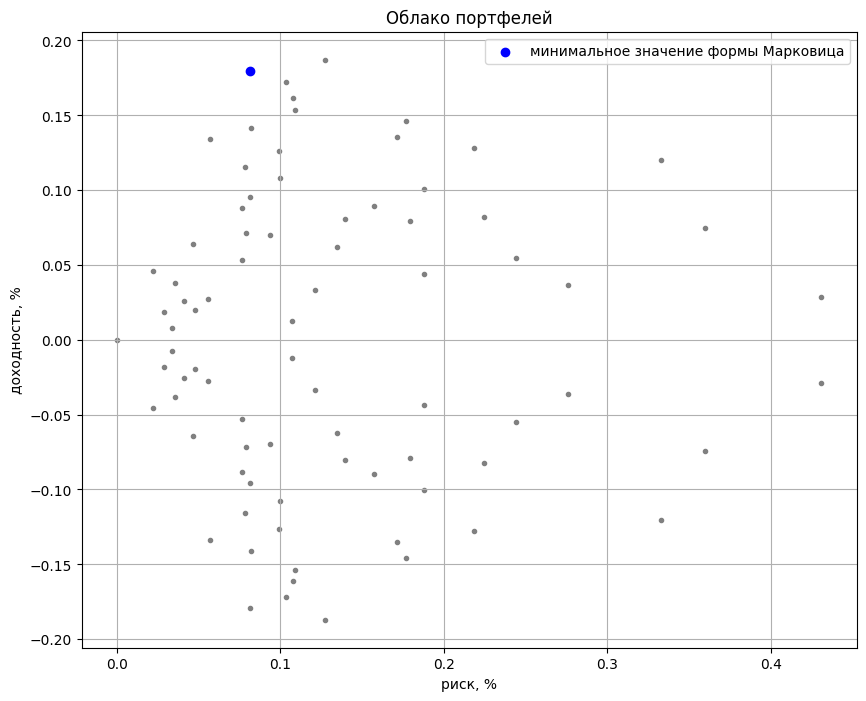

In [186]:
plt.figure(figsize=(10,8))

plt.scatter(risk*100,doh*100,c='gray',marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей")
plt.grid()

minQ = np.argmin(risk-doh)
plt.scatter([risk[minQ]*100],[doh[minQ]*100],c='b',marker='o',label='минимальное значение формы Марковица')

plt.legend()

plt.show()

# QAOA

###Some gates

Экспонента этой матрицы

1 0 0

0 1 0

0 0 0

In [187]:
class QuditSigma0Gate(QuditGate):

    def __init__(self, l1, l2, theta, dimension=3):
        self.l1 = l1
        self.l2 = l2
        self.theta = theta
        super().__init__(dimension=dimension)

    def _unitary_(self):
        N = self.d
        sigma_0 = generalized_sigma(0, self.l1, self.l2, dimension=N)
        u = scipy.linalg.expm(-1j * self.theta * sigma_0)

        return u

    def get_unitary(self):
        return self._unitary_()

    def _circuit_diagram_info_(self, args):
        self.symbol = 'Sigma0'
        SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
        SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
        return f'{self.symbol}{str(self.l1).translate(SUB)}{str(self.l2).translate(SUP)}' + f'({nice_repr(self.theta)})'

QuditSigma0Gate(0, 1, np.pi).get_unitary().round(decimals=0)

array([[-1.-0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.-0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

In [188]:
class QuquartDepolarizingChannel(QuditGate):

    def __init__(self, p1=None, dimension=3):
        super().__init__(dimension=dimension, num_qubits=1)

        # Calculation of the parameter p based on average experimental error of single qudit gate
        if p1 is None:
            f1 = 0.99
            self.p1 = (1 - f1)
        else:
            self.p1 = p1

        self.mixture_probabilities = np.ones(self.d ** 2) * self.p1 / (self.d ** 2 - 1)
        self.mixture_probabilities[0] = (1 - self.p1)  # identity probability

    def _mixture_(self):

        x_unitary = QuditGeneralizedXGate(dimension=self.d).get_unitary()
        z_unitary = QuditGeneralizedZGate(dimension=self.d).get_unitary()

        ps = []
        for alpha in range(self.d):
            for beta in range(self.d):
                op = np.linalg.matrix_power(x_unitary, alpha) @ np.linalg.matrix_power(z_unitary, beta)
                ps.append(op)

        return tuple(zip(self.mixture_probabilities, ps))

    def get_mixture(self):
        return self._mixture_()

    def _circuit_diagram_info_(self, args):
        return f"Φ(p1={self.p1:.3f})"


In [189]:
class DoubleQuquartDepolarizingChannel(QuditGate):
    def __init__(self, p2=None, dimension=3):
        super().__init__(dimension=dimension, num_qubits=2)

        # Calculation of the parameter p based on average experimental error of single qudit gate
        if p2 is None:
            f2 = 0.96
            self.p2 = (1 - f2)
        else:
            self.p2 = p2

        self.mixture_probabilities = np.ones(self.d ** 4) * self.p2 / (self.d ** 4 - 1)
        self.mixture_probabilities[0] = (1 - self.p2)  # identity probability

    def _mixture_(self):
        ps = []

        x_unitary = QuditGeneralizedXGate(dimension=self.d ** 2).get_unitary()
        z_unitary = QuditGeneralizedZGate(dimension=self.d ** 2).get_unitary()

        for alpha in range(self.d ** 2):
            for beta in range(self.d ** 2):

                op = np.linalg.matrix_power(x_unitary, alpha) @ np.linalg.matrix_power(z_unitary, beta)
                ps.append(op)

        return tuple(zip(self.mixture_probabilities, ps))

    def get_mixture(self):
        return self._mixture_()

    def _circuit_diagram_info_(self, args):
        return f"ΦΦ(p2={self.p2:.3f})", f"ΦΦ(p2={self.p2:.3f})"

### QAOA circuit

In [190]:
cov_matrix = cov.to_numpy()
N = len(cov_matrix)

qudits = cirq.LineQid.range(N, dimension=3)
error_channel = QuquartDepolarizingChannel(dimension=3)
double_error_channel = DoubleQuquartDepolarizingChannel(dimension=3)

In [191]:
def initial_layer(noise_activated=False):

    theta1 = 2 * np.arccos( (2 / 3) ** 0.5)
    theta2 = np.pi / 2
    phi = np.pi / 2
    
    gate = QuditRGate(0, 1, theta1, phi, dimension=3) 
    gate2 = QuditRGate(0, 2, theta2, phi, dimension=3)

    for q in qudits:
        yield gate.on(q)
        yield gate2.on(q)

        if noise_activated:
            yield error_channel.on(q)

In [192]:
def parse_ising_string(ising_string):
    result = {
        'single': {},
        'squared_single': {},
        'mix': {}
    }

    spl = ising_string.split(' + ')

    for elem in spl:
        if elem[-2:] == '^2' and elem.count('z') == 1:
            k = int(elem[:elem.find('z')])
            i = int(elem[-3])
            result['squared_single'][i] = k

        elif elem.count('z') == 1:
            k = int(elem[:elem.find('z')])
            i = int(elem[-1])
            result['single'][i] = k

        elif elem.count('z') == 2:
            k = int(elem[:elem.find('z')])

            i1 = int(elem[elem.find('z') + 1])
            i2 = int(elem[elem.rfind('z') + 1])
            
            result['mix'][(i1, i2)] = k

    return result




ising_string = '4z1 + -5z1 + 5z7^2 + 13z3z8'
print(parse_ising_string(ising_string))

{'single': {1: -5}, 'squared_single': {7: 5}, 'mix': {(3, 8): 13}}


In [193]:
def gamma_layer(gamma_value, ising_interacions, noise_activated=False):

    for i, val in ising_interacions['single'].items():
        q0 = qudits[i]
        gate = QuditRGate(0, 1, 2 * gamma_value  * val, 0, dimension=3) 
        yield gate.on(q0)

        if noise_activated:
            yield error_channel.on(q0)


    for i, val in ising_interacions['squared_single'].items():
        q0 = qudits[i]
        gate = QuditSigma0Gate(0, 1, 2 * gamma_value  * val)
        yield gate.on(q0)

        if noise_activated:
            yield error_channel.on(q0)
        

    for ind, val in ising_interacions['mix'].items():  
        i, j = ind

        q0 = qudits[i]
        q1 = qudits[j]

        gamma_cost = gamma_value * val
        costgate = QuditZZGate(0, 1, gamma_cost, dimension=3)

        yield costgate.on(q0, q1)

        if noise_activated:
            yield double_error_channel.on(q0, q1)

In [194]:
def beta_layer(beta_value, noise_activated=False):

    theta1 = round(2 * np.arccos( (2 / 3) ** 0.5), 3)
    theta2 =  round(np.pi / 2, 3)
    phi =  round(np.pi / 2, 3)

    mixgate = QuditRGate(0, 1, theta1 * beta_value, phi, dimension=3) 
    mixgate2 = QuditRGate(0, 2, theta2 * beta_value, phi, dimension=3) 

    for q in qudits:
         yield mixgate.on(q)
    for q in qudits:
         yield mixgate2.on(q)
    if noise_activated:
        for q in qudits:
            yield error_channel.on(q)

In [195]:
def qaoa_layer(gamma_value, beta_value, ising_interacions, noise_activated=False):
    layer = cirq.Circuit()

    # Implement the U(gamma, C) operator.
    layer.append(gamma_layer(gamma_value, ising_interacions, noise_activated=noise_activated))

    # Implement the U(beta, B) operator.
    layer.append(beta_layer(beta_value, noise_activated=noise_activated), strategy=InsertStrategy.NEW_THEN_INLINE)

    return layer

In [196]:
def qaoa_circuit(parameters, ising_interacions, noise_activated=False):

    N_layers = len(parameters) // 2
    qc = cirq.Circuit()

    qc.append(initial_layer(noise_activated=noise_activated))

    for i in range(N_layers):
        gamma_value, beta_value = parameters[2 * i], parameters[2 * i + 1]

        layer = qaoa_layer(gamma_value, beta_value, ising_interacions, noise_activated=noise_activated)
        qc.append(layer)
    
    return qc

###Try QAOA circuit

In [197]:
noise_activated = False

{'single': {0: 4, 2: -5}, 'squared_single': {1: 5}, 'mix': {(0, 1): 13, (2, 3): 2}}







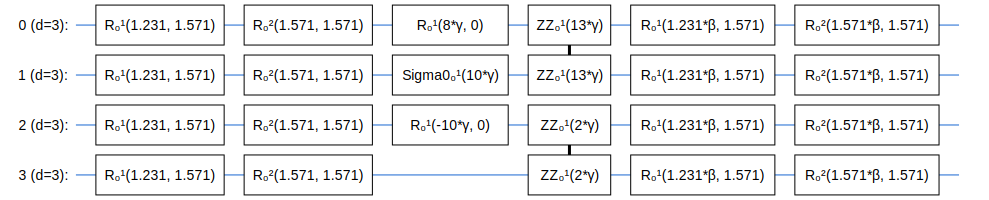

In [198]:
gamma = sympy.Symbol("γ")
beta = sympy.Symbol("β")

pars = gamma, beta

ising_string = '4z0 + -5z2 + 5z1^2 + 13z0z1 + 2z2z3'
ising_interacions = parse_ising_string(ising_string)
print(ising_interacions)

qc = qaoa_circuit(pars, ising_interacions, noise_activated)
print('\n' * 4)
SVGCircuit(qc)

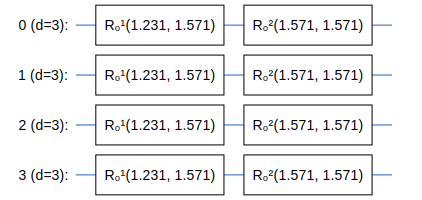

In [199]:
gamma1 = 2
beta1 = 3

pars = ()


qc = qaoa_circuit(pars, ising_interacions)

sim = cirq.Simulator()
state_vector_out = sim.simulate(qc).final_state_vector

SVGCircuit(qc)

###Objective calculation

Доходности всех тернарных портфелей

In [200]:
markovitz_values = []
C = 1 # параметр модели марковица

for s in ternary_portfolio:
    profit_amount = np.matmul(R.values,s)
    risk_amount = np.matmul(np.matmul(s,cov.values),s)
    markovitz_values.append(risk_amount * C - profit_amount)

Objective calculation from final state vector

In [201]:
def objective_function(parameters, objective_values=markovitz_values, ising_interacions=ising_interacions, noise_activated=False):
   
    qc = qaoa_circuit(parameters, ising_interacions, noise_activated)

    if not noise_activated:
        sim = cirq.Simulator()
        state_vector_out = sim.simulate(qc).final_state_vector
        probabilities = (np.abs(state_vector_out) ** 2).real

    else:
        sim = cirq.DensityMatrixSimulator()
        density_matrix_out = sim.simulate(qc).final_density_matrix
        probabilities = (np.diagonal(density_matrix_out)).real

    energy = np.sum(probabilities * objective_values)
    return energy


pars = np.array([1, 2, 3, 4]) * 10000
objective_function(pars)

0.0018806668729267222

#Sample hamiltonians

### H =  z1 + z2

In [202]:
sum_en_values = []

for s in ternary_portfolio:
    a = (s[2] + 2) % 3 - 1
    b = (s[3] + 2) % 3 - 1
    sum_en_values.append(a + b)

print(*sum_en_values)

0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2 0 1 -1 1 2 0 -1 0 -2


In [203]:
ising_string = '1z0 + 1z1'
ising_interactions = parse_ising_string(ising_string)
ising_interactions 

{'single': {0: 1, 1: 1}, 'squared_single': {}, 'mix': {}}

In [204]:
obj_vals = sum_en_values
ising_interacions = ising_interacions 

x0 = np.random.randint(10000, 100000, size=4)

In [207]:
obj_list = []

global_method = 'COBYLA'

def callback_tracker(xi):
    obj_value = objective_function(xi, objective_values=sum_en_values, ising_interacions=ising_interactions, noise_activated=False)
    obj_list.append(obj_value)

res = minimize(objective_function, x0, args=(sum_en_values, ising_interacions, False), method=global_method, callback=callback_tracker, options={'maxiter':40})

In [208]:
obj_list_noise = []

def callback_tracker(xi):
    obj_value = objective_function(xi, objective_values=sum_en_values, ising_interacions=ising_interactions, noise_activated=True)
    obj_list_noise.append(obj_value)
    
res2 = minimize(objective_function, x0, args=(sum_en_values, ising_interacions, True), method=global_method, callback=callback_tracker, options={'maxiter':40})

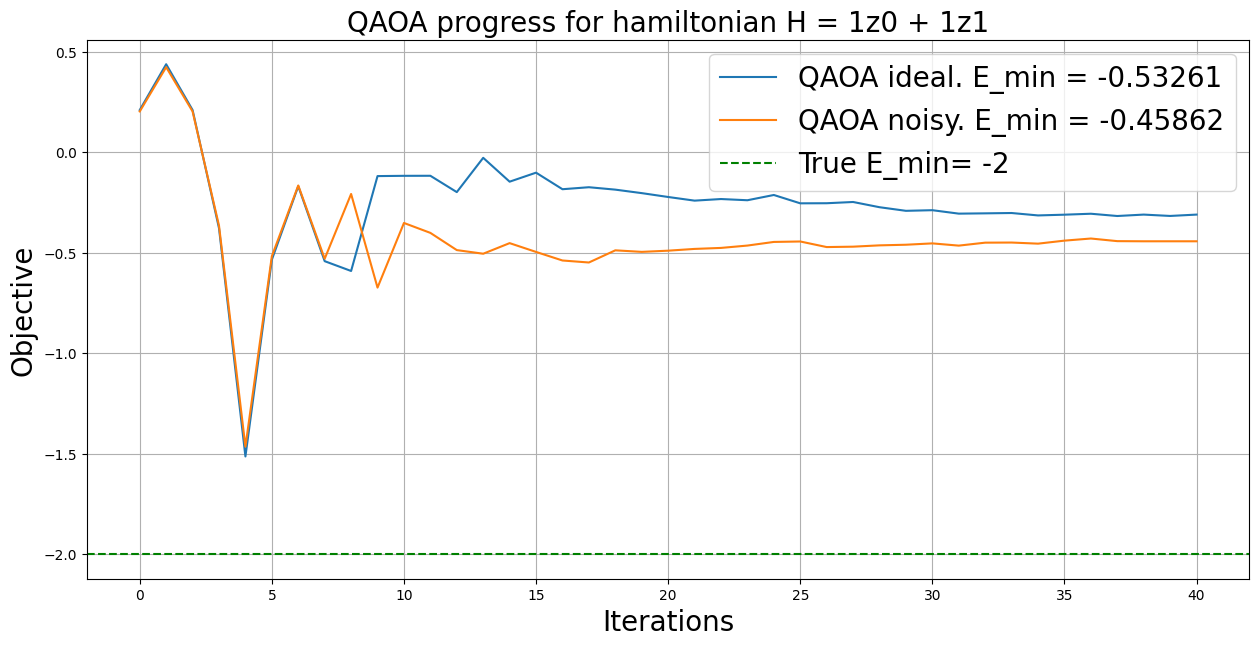

In [209]:
plt.figure(figsize=(15, 7))
plt.title(f"QAOA progress for hamiltonian H = {ising_string}", fontsize=20)

x = list(range(len(obj_list)))
plt.plot(x, obj_list, label=f'QAOA ideal. E_min = {round(res.fun, 5)}')

x2 = list(range(len(obj_list_noise)))
plt.plot(x2, obj_list_noise , label=f'QAOA noisy. E_min = {round(res2.fun, 5)}')

plt.axhline(y=np.min(sum_en_values), color='g', linestyle='--', label=f'True E_min= {round(np.min(sum_en_values), 5)}')

plt.grid()
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.legend(fontsize=20, loc='upper right')


plt.show()

### H = - (z1 + z2)

In [ ]:
sum_en_values = []

for s in ternary_portfolio:
    a = (s[2] + 2) % 3 - 1
    b = (s[3] + 2) % 3 - 1
    sum_en_values.append(-a - b)

print(*sum_en_values)

In [ ]:
ising_string = '-1z0 + -1z1'
ising_interacions = parse_ising_string(ising_string)
ising_interacions 

In [ ]:
obj_vals = sum_en_values
ising_interacions = ising_interacions 

x0 = np.random.randint(10000, 100000, size=4)

In [ ]:
obj_list = []

def callback_tracker(xi):
    obj_value = objective_function(xi, objective_values=sum_en_values)
    obj_list.append(obj_value)

res = minimize(objective_function, x0, args=(sum_en_values, ising_interacions, False), method=global_method, callback=callback_tracker, options={'maxiter':40})

In [ ]:
obj_list_noise = []

def callback_tracker(xi):
    obj_value = objective_function(xi, objective_values=sum_en_values, noise_activated=True)
    obj_list_noise.append(obj_value)
    
res2 = minimize(objective_function, x0, args=(sum_en_values, ising_interacions, True), method=global_method, callback=callback_tracker, options={'maxiter':40})

In [ ]:
plt.figure(figsize=(15, 7))
plt.title(f"QAOA progress for hamiltonian H = {ising_string}", fontsize=20)

x = list(range(len(obj_list)))
plt.plot(x, obj_list, label=f'QAOA ideal. E_min = {round(res.fun, 5)}')

x2 = list(range(len(obj_list_noise)))
plt.plot(x2, obj_list_noise , label=f'QAOA noisy. E_min = {round(res2.fun, 5)}')

plt.axhline(y=np.min(sum_en_values), color='g', linestyle='--', label=f'True E_min= {round(np.min(sum_en_values), 5)}')

plt.grid()
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.legend(fontsize=20, loc='upper right')


plt.show()

## Layer dependency

In [ ]:
ising_string = '1z1^2 + 2z1z2 + 1z2^2'
ising_interacions = parse_ising_string(ising_string)
ising_interacions 

In [ ]:
sample3_ham_values = []

for s in ternary_portfolio:
    z1 = (s[1] + 2) % 3 - 1
    z2 = (s[2] + 2) % 3 - 1
    sample3_ham_values.append(z1 ** 2 + 2 * z1 * z2 + z2 ** 2)

print(*sample3_ham_values)

In [ ]:
obj_vals = sample3_ham_values
ising_interacions = ising_interacions 

x0 = np.random.randint(10000, 100000, size=2)

In [ ]:
qc = qaoa_circuit(pars, ising_interacions, noise_activated)
SVGCircuit(qc)

In [ ]:
qaoa_results_ideal = dict()
qaoa_results_noisy = dict()

x0 = np.random.randint(30000, 100000, size=2)

best_pars = []
best_pars2 = []

for layer_number in range(1, 9, 1):

    print(f'Layer = {layer_number}')

    if len(best_pars) >  0:
        x0 = np.concatenate((best_pars, [0, 0]))
        print(x0)

    res = minimize(objective_function, x0, args=(obj_vals, ising_interacions, False), method=global_method, options={'maxiter':40})

    if len(best_pars2) >  0:
        x0 = np.concatenate((best_pars2, [0, 0]))
        print(x0)

    res2 = minimize(objective_function, x0, args=(obj_vals, ising_interacions, True), method=global_method, options={'maxiter':40})

    best_pars = res.x
    best_pars2 = res2.x

    qaoa_results_ideal[layer_number] = res.fun
    qaoa_results_noisy[layer_number] = res2.fun

In [ ]:
plt.figure(figsize=(15, 7))
plt.title(f"Layer dependency {ising_string}", fontsize=30)

lists = qaoa_results_ideal.items()
x, y = zip(*lists)
plt.plot(x, y, label=f'QAOA ideal. E_min = {round(res.fun, 5)}')


lists = qaoa_results_noisy.items()
x, y = zip(*lists)
plt.plot(x, y, label=f'QAOA noisy. E_min = {round(res2.fun, 5)}')

plt.grid()
plt.xlabel("Layers", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.legend(fontsize=10, loc='upper right')

plt.axhline(y=np.min(obj_vals), color='g', linestyle='--', label=f'True E_min= {round(np.min(sum_en_values), 5)}')

plt.show()

# Quantum financial optimization

In [210]:
financial_interactions = {'single': {}, 'squared_single':{}, 'mix': {}}

for i in range(len(R)):
    financial_interactions['single'][i] = R[i]

for i in range(len(cov)):
    for j in range(i + 1, len(cov)):
        financial_interactions['mix'][(i, j)] = cov_matrix[i][j]

financial_interactions

{'single': {0: 0.0002584869251870288,
  1: 0.00045722130252312374,
  2: -0.0010795237356905065,
  3: 7.554428197050979e-05},
 'squared_single': {},
 'mix': {(0, 1): 7.82997263359884e-05,
  (0, 2): 0.0004196128522277875,
  (0, 3): 0.0002311426572143922,
  (1, 2): 6.562488356903065e-05,
  (1, 3): 0.00010202003834942264,
  (2, 3): 0.00027442324058206635}}

In [211]:
obj_vals = markovitz_values
ising_interacions = financial_interactions

###Custom blackbox optimization technique


In [212]:
import multiprocessing as mp
import numpy as np
import scipy.optimize as op
import logging
from typing import Callable


logging.basicConfig(
    format="%(levelname)-8s %(message)s %(asctime)s", datefmt="%m-%d %H:%M:%S"
)
logger = logging.getLogger("blackbox")
logger.setLevel(logging.INFO)


def minimize(
    f: Callable,
    domain: list,
    budget: int,
    batch: int,
    rho0: float = 0.5,
    p: float = 1.0,
    executor: Callable = mp.Pool,
) -> dict:
    """Minimize given expensive black-box function
    Args:
        f (Callable): objective function to be minimized
        domain (list): ranges for each parameter
        budget (int): total number of function calls available
        batch (int): number of function calls evaluated simultaneously (in parallel)
        rho0 (float, optional): initial "balls density". Defaults to 0.5
        p (float, optional): rate of "balls density" decay (p=1 - linear, p>1 - faster, 0<p<1 - slower). Defaults to 1.0
        executor (Callable, optional): should have a map method and behave as a context manager. Defaults to mp.Pool
    Returns:
        dict: a dictionary with results. Contains the following keys:
        "best_x": best solution
        "best_f": corresponding best function value
        "all_xs": all points that were evaluated
        "all_fs": all corresponding function values
    """
    # space size
    d = len(domain)

    # adjusting the budget to the batch size
    if budget % batch != 0:
        budget = budget - budget % batch + batch
        logger.info(f"budget was adjusted to be {budget}")

    # default global-vs-local assumption (50-50)
    n = budget // 2
    if n % batch != 0:
        n = n - n % batch + batch
    m = budget - n

    # n has to be greater than d
    if n <= d:
        logger.error("budget is not sufficient")
        return

    # go from normalized values (unit cube) to absolute values (box)
    def cubetobox(x):
        return [domain[i][0] + (domain[i][1] - domain[i][0]) * x[i] for i in range(d)]

    # generating R-sequence
    points = np.zeros((n, d + 1))
    points[:, 0:-1] = build_rseq(n, d)

    # initial sampling
    for i in range(n // batch):
        logger.info(
            f"evaluating batch {i+1}/{(n+m)//batch} (samples {i*batch+1}..{(i+1)*batch}/{n+m})"
        )

        with executor() as e:
            points[batch * i : batch * (i + 1), -1] = list(
                e.map(
                    f, list(map(cubetobox, points[batch * i : batch * (i + 1), 0:-1]))
                )
            )

    # normalizing function values
    fmax = max(abs(points[:, -1]))
    points[:, -1] = points[:, -1] / fmax

    v1 = compute_volume_unit_ball(d)

    # subsequent iterations (current subsequent iteration = i*batch+j)
    for i in range(m // batch):
        logger.info(
            f"evaluating batch {n//batch+i+1}/{(n+m)//batch} (samples {n+i*batch+1}..{n+(i+1)*batch}/{n+m})"
        )

        # sampling next batch of points
        fit = build_rbf(points)
        points = np.append(points, np.zeros((batch, d + 1)), axis=0)

        for j in range(batch):
            r = (
                (rho0 * ((m - 1.0 - (i * batch + j)) / (m - 1.0)) ** p)
                / (v1 * (n + i * batch + j))
            ) ** (1.0 / d)
            constraints = [
                {
                    "type": "ineq",
                    "fun": lambda x, localk=k: np.linalg.norm(
                        np.subtract(x, points[localk, 0:-1])
                    )
                    - r,
                }
                for k in range(n + i * batch + j)
            ]
            while True:
                minfit = op.minimize(
                    fit,
                    np.random.rand(d),
                    method="SLSQP",
                    bounds=[[0.0, 1.0]] * d,
                    constraints=constraints,
                )
                if np.isnan(minfit.x)[0] == False:
                    break
            points[n + i * batch + j, 0:-1] = np.copy(minfit.x)

        with executor() as e:
            points[n + batch * i : n + batch * (i + 1), -1] = (
                list(
                    e.map(
                        f,
                        list(
                            map(
                                cubetobox,
                                points[n + batch * i : n + batch * (i + 1), 0:-1],
                            )
                        ),
                    )
                )
                / fmax
            )

    # rescaling result
    points[:, 0:-1] = list(map(cubetobox, points[:, 0:-1]))
    points[:, -1] = points[:, -1] * fmax

    logger.info("DONE")

    return {
        "best_x": points[points[:, -1].argsort()][0, :-1],
        "best_f": points[points[:, -1].argsort()][0, -1],
        "all_xs": points[:, :-1],
        "all_fs": points[:, -1],
    }


def compute_volume_unit_ball(d: int) -> float:
    """computes volume of d-dimentional ball (r=1)
    Args:
        d (int): space dimension
    Returns:
        float: volume
    """
    if d % 2 == 0:
        v1 = np.pi ** (d / 2) / np.math.factorial(int(d / 2))
    else:
        v1 = (
            2
            * (4 * np.pi) ** ((d - 1) / 2)
            * np.math.factorial(int(d - 1) / 2)
            / np.math.factorial(int(d))
        )
    return v1


def build_rseq(n: int, d: int) -> np.ndarray:
    """build R-sequence (array of points uniformly placed in d-dimensional unit cube):
    http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/
    Args:
        n (int): number of points
        d (int): space dimention
    Returns:
        np.ndarray: R-sequence
    """
    phi = 2
    for i in range(10):
        phi = pow(1 + phi, 1.0 / (d + 1))

    alpha = np.array([pow(1.0 / phi, i + 1) for i in range(d)])
    rseq = np.array([(0.5 + alpha * (i + 1)) % 1 for i in range(n)])

    return rseq


def build_rbf(points: np.ndarray) -> Callable:
    """build RBF-fit for given points (see Holmstrom, 2008 for details)
    Args:
        points (np.ndarray): array of multi-d points with corresponding values
        [[x1, x2, .., xd, val], ...]
    Returns:
        Callable: constructed fit
    """
    n = len(points)
    d = len(points[0]) - 1

    def basis(r):
        return r * r * r

    phi = [
        [
            basis(np.linalg.norm(np.subtract(points[i, 0:-1], points[j, 0:-1])))
            for j in range(n)
        ]
        for i in range(n)
    ]

    p = np.ones((n, d + 1))
    p[:, 0:-1] = points[:, 0:-1]

    f = points[:, -1]

    m = np.zeros((n + d + 1, n + d + 1))
    m[0:n, 0:n] = phi
    m[0:n, n : n + d + 1] = p
    m[n : n + d + 1, 0:n] = np.transpose(p)

    v = np.zeros(n + d + 1)
    v[0:n] = f

    try:
        sol = np.linalg.solve(m, v)
    except:
        # helps with singular matrices
        logger.warning(
            "Singular matrix occurred during RBF-fit construction. RBF-fit might be inaccurate!"
        )
        sol = np.linalg.lstsq(m, v)[0]

    lam, b, a = sol[0:n], sol[n : n + d], sol[n + d]

    def fit(x):
        return (
            sum(
                lam[i] * basis(np.linalg.norm(np.subtract(x, points[i, 0:-1])))
                for i in range(n)
            )
            + np.dot(b, x)
            + a
        )

    return fit

### L = 2 layer

In [213]:
domain = [[-100, 100] for _ in range(4)]

def obj_wrapper(x):
    return objective_function(x, obj_vals, ising_interacions, False)

result = minimize(f=obj_wrapper, domain=domain, budget=100, batch=2)

# best result
print(result["best_x"])
print(result["best_f"])

obj_list = result["all_fs"]

obj_list_noise = []

INFO:blackbox:evaluating batch 1/50 (samples 1..2/100)
INFO:blackbox:evaluating batch 2/50 (samples 3..4/100)
INFO:blackbox:evaluating batch 3/50 (samples 5..6/100)
INFO:blackbox:evaluating batch 4/50 (samples 7..8/100)
INFO:blackbox:evaluating batch 5/50 (samples 9..10/100)
INFO:blackbox:evaluating batch 6/50 (samples 11..12/100)
INFO:blackbox:evaluating batch 7/50 (samples 13..14/100)
INFO:blackbox:evaluating batch 8/50 (samples 15..16/100)
INFO:blackbox:evaluating batch 9/50 (samples 17..18/100)
INFO:blackbox:evaluating batch 10/50 (samples 19..20/100)
INFO:blackbox:evaluating batch 11/50 (samples 21..22/100)
INFO:blackbox:evaluating batch 12/50 (samples 23..24/100)
INFO:blackbox:evaluating batch 13/50 (samples 25..26/100)
INFO:blackbox:evaluating batch 14/50 (samples 27..28/100)
INFO:blackbox:evaluating batch 15/50 (samples 29..30/100)
INFO:blackbox:evaluating batch 16/50 (samples 31..32/100)
INFO:blackbox:evaluating batch 17/50 (samples 33..34/100)
INFO:blackbox:evaluating batch 1

[25.38920946 -9.53537622 75.2057014  62.46134723]
1.3092246316276193e-05


In [ ]:
def obj_wrapper_noise(x):
    return objective_function(x, obj_vals, ising_interacions, True)

result_noise = minimize(f=obj_wrapper_noise, domain=domain, budget=20, batch=5)

# best result
print(result_noise["best_x"])
print(result_noise["best_f"])

obj_list_noise = result_noise["all_fs"]

INFO:blackbox:evaluating batch 1/4 (samples 1..5/20)
INFO:blackbox:evaluating batch 2/4 (samples 6..10/20)
INFO:blackbox:evaluating batch 3/4 (samples 11..15/20)
INFO:blackbox:evaluating batch 4/4 (samples 16..20/20)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

plt.figure(figsize=(15, 7))
plt.title("QAOA progress")

x = list(range(len(obj_list)))
plt.plot(x, obj_list, label=f'QAOA without noise')

x2 = list(range(len(obj_list_noise)))
plt.plot(x2, obj_list_noise , label=f'QAOA with noise')

plt.axhline(y=np.min(obj_vals), color='g', linestyle='--')

plt.grid()
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.legend(fontsize=10, loc='upper right')


plt.show()

#### Loop over layers

In [ ]:
qaoa_results_ideal = dict()
qaoa_results_noisy = dict()

x0 = np.random.randint(10000, 100000, size=2)

best_pars = []
best_pars2 = []

for layer_number in range(1, 6, 1):

    print(f'Layer = {layer_number}')

    if len(best_pars) >  0:
        x0 = np.concatenate((best_pars, [0, 0]))
        print(x0)

    res = minimize(objective_function, x0, args=(obj_vals, ising_interacions, False), method=global_method, options={'maxiter':40})

    if len(best_pars2) >  0:
        x0 = np.concatenate((best_pars2, [0, 0]))
        print(x0)

    res2 = minimize(objective_function, x0, args=(obj_vals, ising_interacions, True), method=global_method, options={'maxiter':40})

    best_pars = res.x
    best_pars2 = res2.x

    qaoa_results_ideal[layer_number] = res.fun
    qaoa_results_noisy[layer_number] = res2.fun

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Layer dependency finance")

lists = qaoa_results_ideal.items()
x, y = zip(*lists)
plt.plot(x, y, label=f'QAOA without noise')


lists = qaoa_results_noisy.items()
x, y = zip(*lists)
plt.plot(x, y, label=f'QAOA with noise')

plt.grid()
plt.xlabel("Layers", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.legend(fontsize=10, loc='upper right')

plt.axhline(y=np.min(obj_vals), color='g', linestyle='--')

plt.show()